#### library

In [105]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine, Unit
import sys
from datetime import datetime, timedelta
from geopy.distance import great_circle

from sklearn.neighbors import KDTree, BallTree
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor, GradientBoostingRegressor
import optuna
import catboost as cb

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

utils_directory = os.path.abspath('..')
sys.path.append(utils_directory)

import preprocessing

from utils.constant_utils import Directory
from utils import common_utils

import model
from inference import *

features_directory = os.path.abspath('../features')
sys.path.append(features_directory)

from clustering_features import *
from count_features import *
from distance_features import *
from other_features import *

#### data load

In [106]:
print("Start the main.py successfully!")

'''
name : 실험자 이름입니다.
title : result 폴더에 저장될 실험명을 지정합니다.
'''
name = 'eun'
title = 'cluster,timefeature,categorical,drop,gangnam,xgb1000'

print("total data load ...")
df = common_utils.merge_data(Directory.train_data, Directory.test_data)
df = preprocessing.handle_age_outliers(df)
print(df.shape)
df_train = df[df['type'] == 'train']
df_train = preprocessing.handle_duplicates(df_train)
df_test = df[df['type'] == 'test']

df = pd.concat([df_train, df_test])

Start the main.py successfully!
total data load ...
(1947949, 12)


In [107]:
def add_recent_rent_in_building(total_df):
    total_df['contract_date'] = total_df['contract_year_month'] * 100 + total_df['contract_day']
    
    df_train = total_df[total_df['type'] == 'train'].copy()
    df_test = total_df[total_df['type'] == 'test'].copy()
    
    df_train_sorted = df_train.sort_values(by=['latitude', 'longitude', 'built_year', 'area_m2', 'contract_date'])
    
    df_train_sorted['recent_rent_in_building'] = df_train_sorted.groupby(['latitude', 'longitude', 'built_year', 'area_m2'])['deposit'].shift(1)
    df_train_sorted['recent_rent_in_building'].fillna(df_train_sorted['deposit'], inplace=True)
    
    recent_rent_index = df_train_sorted.groupby(['latitude', 'longitude', 'built_year', 'area_m2'])['recent_rent_in_building'].nth(-1).index
    recent_rent_df = df_train_sorted.loc[recent_rent_index]
    
    df_test_merged = df_test.merge(recent_rent_df[['latitude','longitude','built_year','area_m2','recent_rent_in_building']], on=['latitude','longitude','built_year','area_m2'], how='left').set_index(df_test.index)
    df_test_merged.fillna(0, inplace=True)
    
    total_df = pd.concat([df_train_sorted.sort_index(),df_test_merged])
    
    return total_df

In [108]:
new_df_fe = add_recent_rent_in_building(df)
new_df_fe.head(3)

,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,type,interest_rate,contract_date,recent_rent_in_building
0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0,train,1.78,20190625,17000.0
1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0,train,1.26,20200326,17000.0
2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0,train,1.26,20200328,23000.0


In [277]:
def add_recent_rent_in_building(total_df):
    # 계약 연월일을 하나의 컬럼으로 합침 (연월일과 계약일을 합쳐서 날짜순으로 처리)
    total_df['contract_date'] = total_df['contract_year_month'] * 100 + total_df['contract_day']
    
    # Train 데이터와 Test 데이터를 분리
    df_train = total_df[total_df['type'] == 'train'].copy()
    df_test = total_df[total_df['type'] == 'test'].copy()

    # train 데이터를 위도, 경도, 건축년도, 면적별로 정렬하여 가장 최근 거래 찾기
    df_train = df_train.sort_values(by=['latitude', 'longitude', 'built_year', 'area_m2', 'contract_date'])

    # train 데이터에서 각 그룹의 가장 최근 거래된 전세가 계산
    df_train['recent_rent_in_building'] = df_train.groupby(['latitude', 'longitude', 'built_year', 'area_m2'])['deposit'].transform(lambda x: x.shift(1))

    # 최근 전세가 정보를 사용하기 위한 매핑 테이블 생성 (위도, 경도, 건축년도, 면적이 키)
    recent_rent_map = df_train.groupby(['latitude', 'longitude', 'built_year', 'area_m2'])['recent_rent_in_building'].last().reset_index()

    # test 데이터에 train 데이터의 최근 전세가 정보를 매핑 (join)
    df_test = df_test.merge(recent_rent_map, on=['latitude', 'longitude', 'built_year', 'area_m2'], how='left')

    # NaN 값은 0으로 채움 (해당 아파트의 과거 전세가 정보가 없을 때)
    df_test['recent_rent_in_building'].fillna(0, inplace=True)

    # 계약 날짜 관련 컬럼 제거
    df_train = df_train.drop(columns=['contract_date'])

    # 원래 데이터프레임에 업데이트된 train과 test를 합쳐서 인덱스 정리
    total_df.loc[total_df['type'] == 'train', 'recent_rent_in_building'] = df_train['recent_rent_in_building']
    total_df.loc[total_df['type'] == 'test', 'recent_rent_in_building'] = df_test['recent_rent_in_building']

    return total_df


# 해당 지역(위도, 경도)의 과거 평균 전세가
def add_avg_rent_in_past_year(total_df):
    # train과 test 데이터를 분리
    df_train = total_df[total_df['type'] == 'train'].copy()
    df_test = total_df[total_df['type'] == 'test'].copy()
    
    # 연도를 추출
    df_train['contract_year'] = df_train['contract_year_month'] // 100
    
    # train 데이터에서 위도, 경도, 연도별 평균 전세가 계산
    df_train['avg_rent_in_past_year'] = df_train.groupby(['latitude', 'longitude', 'contract_year'])['deposit'].transform(lambda x: x.shift(1).expanding().mean())
    
    # test 데이터에 과거 평균 전세가를 추가 (train 데이터만 사용)
    avg_rent_map = df_train.groupby(['latitude', 'longitude', 'contract_year'])['avg_rent_in_past_year'].last().reset_index()
    df_test['contract_year'] = df_test['contract_year_month'] // 100
    df_test = df_test.merge(avg_rent_map, on=['latitude', 'longitude', 'contract_year'], how='left')
    
    # NaN 값은 0으로 채움
    df_train['avg_rent_in_past_year'].fillna(0, inplace=True)
    df_test['avg_rent_in_past_year'].fillna(0, inplace=True)
    
    # 불필요한 컬럼 제거
    df_train = df_train.drop(columns=['contract_year'])
    df_test = df_test.drop(columns=['contract_year'])
    
    # 원래 데이터프레임에 업데이트
    total_df.loc[total_df['type'] == 'train', 'avg_rent_in_past_year'] = df_train['avg_rent_in_past_year']
    total_df.loc[total_df['type'] == 'test', 'avg_rent_in_past_year'] = df_test['avg_rent_in_past_year']
    
    return total_df

# 층별 전세가 평균
def add_avg_rent_by_floor(total_df):
    df_train = total_df[total_df['type'] == 'train'].copy()
    df_test = total_df[total_df['type'] == 'test'].copy()
    
    # train 데이터에서 층별 평균 전세가 계산
    df_train['avg_rent_by_floor'] = df_train.groupby(['latitude', 'longitude', 'built_year', 'floor'])['deposit'].transform(lambda x: x.shift(1).expanding().mean())
    
    # test 데이터에 층별 평균 전세가를 추가 (train 데이터만 사용)
    avg_rent_floor_map = df_train.groupby(['latitude', 'longitude', 'built_year', 'floor'])['avg_rent_by_floor'].last().reset_index()
    df_test = df_test.merge(avg_rent_floor_map, on=['latitude', 'longitude', 'built_year', 'floor'], how='left')
    
    df_train['avg_rent_by_floor'].fillna(0, inplace=True)
    df_test['avg_rent_by_floor'].fillna(0, inplace=True)
    
    # 원래 데이터프레임에 업데이트
    total_df.loc[total_df['type'] == 'train', 'avg_rent_by_floor'] = df_train['avg_rent_by_floor']
    total_df.loc[total_df['type'] == 'test', 'avg_rent_by_floor'] = df_test['avg_rent_by_floor']
    
    return total_df

# 연도별 전세가 상승률
def add_rent_growth_rate(total_df):
    df_train = total_df[total_df['type'] == 'train'].copy()
    df_test = total_df[total_df['type'] == 'test'].copy()

    # 연도를 추출
    df_train['contract_year'] = df_train['contract_year_month'] // 100
    
    # train 데이터에서 연도별 전세가 상승률 계산
    df_train['prev_year_rent'] = df_train.groupby(['latitude', 'longitude', 'contract_year', 'built_year'])['deposit'].transform(lambda x: x.shift(1))
    df_train['rent_growth_rate'] = (df_train['deposit'] - df_train['prev_year_rent']) / df_train['prev_year_rent']
    
    # test 데이터에 전세가 상승률을 추가 (train 데이터만 사용)
    rent_growth_map = df_train.groupby(['latitude', 'longitude', 'contract_year', 'built_year'])['rent_growth_rate'].last().reset_index()
    df_test['contract_year'] = df_test['contract_year_month'] // 100
    df_test = df_test.merge(rent_growth_map, on=['latitude', 'longitude', 'contract_year', 'built_year'], how='left')
    
    df_train['rent_growth_rate'].fillna(0, inplace=True)
    df_test['rent_growth_rate'].fillna(0, inplace=True)
    
    df_train = df_train.drop(columns=['contract_year', 'prev_year_rent'])
    df_test = df_test.drop(columns=['contract_year'])
    
    # 원래 데이터프레임에 업데이트
    total_df.loc[total_df['type'] == 'train', 'rent_growth_rate'] = df_train['rent_growth_rate']
    total_df.loc[total_df['type'] == 'test', 'rent_growth_rate'] = df_test['rent_growth_rate']
    
    return total_df

# 해당 면적의 과거 전세가 변동
def add_avg_rent_by_size(total_df):
    df_train = total_df[total_df['type'] == 'train'].copy()
    df_test = total_df[total_df['type'] == 'test'].copy()
    
    # train 데이터에서 면적별 평균 전세가 계산
    df_train['avg_rent_by_size'] = df_train.groupby(['latitude', 'longitude', 'built_year', 'area_m2'])['deposit'].transform(lambda x: x.shift(1).expanding().mean())
    
    # test 데이터에 면적별 평균 전세가 추가 (train 데이터만 사용)
    avg_rent_size_map = df_train.groupby(['latitude', 'longitude', 'built_year', 'area_m2'])['avg_rent_by_size'].last().reset_index()
    df_test = df_test.merge(avg_rent_size_map, on=['latitude', 'longitude', 'built_year', 'area_m2'], how='left')
    
    df_train['avg_rent_by_size'].fillna(0, inplace=True)
    df_test['avg_rent_by_size'].fillna(0, inplace=True)
    
    # 원래 데이터프레임에 업데이트
    total_df.loc[total_df['type'] == 'train', 'avg_rent_by_size'] = df_train['avg_rent_by_size']
    total_df.loc[total_df['type'] == 'test', 'avg_rent_by_size'] = df_test['avg_rent_by_size']
    
    return total_df

In [278]:
def deposit_feature_engineering(df):
    #df = add_avg_rent_in_past_year(df)
    #print("1 finish")
    df = add_recent_rent_in_building(df)
    print("2 finish")
    #df = add_rent_growth_rate(df)
    #print("3 finish")
    #df = add_avg_rent_by_size(df)
    #print("4 finish")
    #df = add_avg_rent_by_floor(df)
    #print("5 finish")
    return df

In [285]:
# 동일한 아파트(위도, 경도, 건축연도, 면적이 동일한)의 최근 전세가
def add_recent_rent_in_building(total_df):
    total_df['contract_date'] = total_df['contract_year_month'] * 100 + total_df['contract_day']
    
    df_train = total_df[total_df['type'] == 'train'].copy()
    df_test = total_df[total_df['type'] == 'test'].copy()

    df_train = df_train.sort_values(by=['latitude', 'longitude', 'built_year', 'area_m2', 'contract_date'])
    df_train['recent_rent_in_building'] = df_train.groupby(['latitude', 'longitude', 'built_year', 'area_m2'])['deposit'].transform(lambda x: x.shift(1))
    recent_rent_map = df_train.groupby(['latitude', 'longitude', 'built_year', 'area_m2'])['recent_rent_in_building'].last().reset_index()

    df_test = df_test.merge(recent_rent_map, on=['latitude', 'longitude', 'built_year', 'area_m2'], how='left')

    df_test['recent_rent_in_building'].fillna(0, inplace=True)
    df_train = df_train.drop(columns=['contract_date'])

    total_df.loc[total_df['type'] == 'train', 'recent_rent_in_building'] = df_train['recent_rent_in_building']
    total_df.loc[total_df['type'] == 'test', 'recent_rent_in_building'] = df_test['recent_rent_in_building']

    return total_df


# 동일한 아파트(위도, 경도, 건축연도, 면적이 동일한)의 계약년 당시 평균 전세가
def add_avg_rent_in_past_year(total_df):

    df_train = total_df[total_df['type'] == 'train'].copy()
    df_test = total_df[total_df['type'] == 'test'].copy()
    

    df_train['contract_year'] = df_train['contract_year_month'] // 100
    df_train['avg_rent_in_past_year'] = df_train.groupby(['latitude','longitude','built_year','area_m2','contract_year'])['deposit'].transform(lambda x: x.shift(1).expanding().mean())

    avg_rent_map = df_train.groupby(['latitude','longitude','built_year','area_m2','contract_year'])['avg_rent_in_past_year'].last().reset_index()
    df_test['contract_year'] = df_test['contract_year_month'] // 100
    df_test = df_test.merge(avg_rent_map, on=['latitude', 'longitude', 'contract_year'], how='left')
    
    df_train['avg_rent_in_past_year'].fillna(0, inplace=True)
    df_test['avg_rent_in_past_year'].fillna(0, inplace=True)
    
    df_train = df_train.drop(columns=['contract_year'])
    df_test = df_test.drop(columns=['contract_year'])
    
    total_df.loc[total_df['type'] == 'train', 'avg_rent_in_past_year'] = df_train['avg_rent_in_past_year']
    total_df.loc[total_df['type'] == 'test', 'avg_rent_in_past_year'] = df_test['avg_rent_in_past_year']
    
    return total_df

# 가장 최근 두 연도의 거래값을 통한 상승률
def add_recent_rent_growth_rate(total_df):
    df_train = total_df[total_df['type'] == 'train'].copy()
    df_test = total_df[total_df['type'] == 'test'].copy()

    # 연도를 추출
    df_train['contract_year'] = df_train['contract_year_month'] // 100
    df_test['contract_year'] = df_test['contract_year_month'] // 100

    # latitude, longitude, built_year, contract_year 기준으로 전세금 평균 구하기
    df_train_mean = df_train.groupby(['latitude', 'longitude', 'built_year', 'contract_year'])['deposit'].mean().reset_index()

    def calculate_growth_rate(group):
        group = group.sort_values('contract_year', ascending=False)
        
        if len(group) > 1:
            first_value = group.iloc[0]['deposit']
            second_value = group.iloc[1]['deposit']
            # 상승률 계산
            growth_rate = (first_value - second_value) / second_value
        else:
            # 데이터가 하나인 경우
            growth_rate = 0
        return growth_rate

    df_rent_growth_rate = df_train_mean.groupby(['latitude', 'longitude', 'built_year']).apply(calculate_growth_rate).reset_index(name='recent_rent_growth_rate')

    # Train과 Test 데이터에 상승률 병합
    df_train = df_train.merge(df_rent_growth_rate, on=['latitude', 'longitude', 'built_year'], how='left')
    df_test = df_test.merge(df_rent_growth_rate, on=['latitude', 'longitude', 'built_year'], how='left')

    # 결측값을 train 데이터의 평균 상승률로 채우기
    avg_rent_growth_rate = df_train['recent_rent_growth_rate'].mean()
    df_train['recent_rent_growth_rate'].fillna(0, inplace=True)
    df_test['recent_rent_growth_rate'].fillna(0, inplace=True)

    # contract_year 열 삭제
    df_train = df_train.drop(columns=['contract_year'])
    df_test = df_test.drop(columns=['contract_year'])

    # total_df에 컬럼 추가 및 업데이트
    total_df['recent_rent_growth_rate'] = 0  # 초기화
    total_df.loc[total_df['type'] == 'train', 'recent_rent_growth_rate'] = df_train['recent_rent_growth_rate']
    total_df.loc[total_df['type'] == 'test', 'recent_rent_growth_rate'] = df_test['recent_rent_growth_rate']

    return total_df


# 동일한 아파트(위도, 경도, 건축연도)의 동일한 면적별 평균 전세가
def add_avg_rent_by_size(total_df):
    df_train = total_df[total_df['type'] == 'train'].copy()
    df_test = total_df[total_df['type'] == 'test'].copy()
    
    # train 데이터에서 면적별 평균 전세가 계산
    df_train['avg_rent_by_size'] = df_train.groupby(['latitude', 'longitude', 'built_year', 'area_m2'])['deposit'].transform(lambda x: x.shift(1).expanding().mean())
    
    # test 데이터에 면적별 평균 전세가 추가 (train 데이터만 사용)
    avg_rent_size_map = df_train.groupby(['latitude', 'longitude', 'built_year', 'area_m2'])['avg_rent_by_size'].last().reset_index()
    df_test = df_test.merge(avg_rent_size_map, on=['latitude', 'longitude', 'built_year', 'area_m2'], how='left')
    
    avg_rent_size = avg_rent_size_map['avg_rent_by_size'].mean()
    df_train['avg_rent_by_size'].fillna(0, inplace=True)
    df_test['avg_rent_by_size'].fillna(0, inplace=True)
    
    # 원래 데이터프레임에 업데이트
    total_df.loc[total_df['type'] == 'train', 'avg_rent_by_size'] = df_train['avg_rent_by_size']
    total_df.loc[total_df['type'] == 'test', 'avg_rent_by_size'] = df_test['avg_rent_by_size']
    
    return total_df


# 동일한 아파트(위도, 경도, 건축연도)의 동일한 층별 평균 전세가
def add_avg_rent_by_floor(total_df):
    df_train = total_df[total_df['type'] == 'train'].copy()
    df_test = total_df[total_df['type'] == 'test'].copy()
    
    # train 데이터에서 층별 평균 전세가 계산
    df_train['avg_rent_by_floor'] = df_train.groupby(['latitude', 'longitude', 'built_year', 'floor'])['deposit'].transform(lambda x: x.shift(1).expanding().mean())
    
    # test 데이터에 층별 평균 전세가를 추가 (train 데이터만 사용)
    avg_rent_floor_map = df_train.groupby(['latitude', 'longitude', 'built_year', 'floor'])['avg_rent_by_floor'].last().reset_index()
    df_test = df_test.merge(avg_rent_floor_map, on=['latitude', 'longitude', 'built_year', 'floor'], how='left')
    
    avg_rent_size = avg_rent_floor_map['avg_rent_by_floor'].mean()
    df_train['avg_rent_by_floor'].fillna(0, inplace=True)
    df_test['avg_rent_by_floor'].fillna(0, inplace=True)
    
    # 원래 데이터프레임에 업데이트
    total_df.loc[total_df['type'] == 'train', 'avg_rent_by_floor'] = df_train['avg_rent_by_floor']
    total_df.loc[total_df['type'] == 'test', 'avg_rent_by_floor'] = df_test['avg_rent_by_floor']
    
    return total_df

In [286]:
def deposit_feature_engineering(df):
    # df = add_avg_rent_in_past_year(df)
    # print("1 finish")
    df = add_recent_rent_in_building(df)
    print("2 finish")
    # df = add_recent_rent_growth_rate(df)
    # print("3 finish")
    # df = add_avg_rent_by_size(df)
    # print("4 finish")
    # df = add_avg_rent_by_floor(df)
    # print("5 finish")
    return df

In [104]:
new_df_fe = deposit_feature_engineering(df)
new_df_fe.head(3)

2 finish


,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,type,interest_rate,contract_date,recent_rent_in_building
0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0,train,1.78,20190625,17000.0
1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0,train,1.26,20200326,17000.0
2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0,train,1.26,20200328,23000.0


In [109]:
new_df_fe = new_df_fe.drop(columns = ['contract_date'])
new_df_fe['recent_rent_in_building'].fillna(0, inplace=True)
new_df_fe.head(3)

,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,type,interest_rate,recent_rent_in_building
0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0,train,1.78,17000.0
1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0,train,1.26,17000.0
2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0,train,1.26,23000.0


In [110]:
### 클러스터 피처 apply
print("clustering apply ...")
for info_df_name in ['subway_info', 'school_info', 'park_info']:
    info_df = getattr(Directory, info_df_name)  
    df = clustering(new_df_fe, info_df, feat_name=info_df_name, n_clusters=20)

### 이상치 처리
print("start to cleaning outliers...")
df = preprocessing.handle_age_outliers(df)

### 데이터 분할
print("train, valid, test split for preprocessing & feature engineering ...")
train_data_, valid_data_, test_data_ = common_utils.train_valid_test_split(df)


### 데이터 전처리
print("start to preprocessing...")
# type 카테고리화
train_data_ = preprocessing.numeric_to_categoric(train_data_, 'contract_type', {0:'new', 1:'renew', 2:'unknown'})
valid_data_ = preprocessing.numeric_to_categoric(valid_data_, 'contract_type', {0:'new', 1:'renew', 2:'unknown'})
test_data_ = preprocessing.numeric_to_categoric(test_data_, 'contract_type', {0:'new', 1:'renew', 2:'unknown'})

# 중복 제거
train_data_ = preprocessing.handle_duplicates(train_data_)
valid_data_ = preprocessing.handle_duplicates(valid_data_)

# 로그 변환
#df = preprocessing_fn.log_transform(df, 'deposit')


### 피처 엔지니어링
print("start to feature engineering...")
# clustering_feature
print("create clustering features")
train_data, valid_data, test_data = create_clustering_target(train_data_, valid_data_, test_data_)

# distance_features
print("create distance features")
train_data, valid_data, test_data = distance_gangnam(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_nearest_subway_distance(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_nearest_park_distance_and_area(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_nearest_school_distance(train_data, valid_data, test_data)
train_data, valid_data, test_data = weighted_subway_distance(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_nearest_park_distance_and_area(train_data, valid_data, test_data)

# other_features
print("create other features")
train_data, valid_data, test_data = create_temporal_feature(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_sin_cos_season(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_floor_area_interaction(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_sum_park_area_within_radius(train_data, valid_data, test_data)
train_data, valid_data, test_data = shift_interest_rate_function(train_data, valid_data, test_data)
train_data, valid_data, test_data = categorization(train_data, valid_data, test_data, category = 'age')
train_data, valid_data, test_data = categorization(train_data, valid_data, test_data, category = 'floor')
train_data, valid_data, test_data = categorization(train_data, valid_data, test_data, category = 'area_m2')


# count_features
print("create count features")
train_data, valid_data, test_data = transaction_count_function(train_data, valid_data, test_data)
# 위의 함수를 바로 실행하기 위한 구조 : data/transaction_data에 train/valid/test_transaction_{month}.txt 구조의 파일이 있어야함
train_data, valid_data, test_data = create_subway_within_radius(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_school_within_radius(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_school_counts_within_radius_by_school_level(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_place_within_radius(train_data, valid_data, test_data)

clustering apply ...
start to cleaning outliers...
train, valid, test split for preprocessing & feature engineering ...
start to preprocessing...
start to feature engineering...
create clustering features
create distance features
create other features
create count features
Loading pre-calculated transaction data for 3 months.


In [111]:
print("standardization...")
train_data_, valid_data_, test_data_ = preprocessing.standardization(train_data, valid_data, test_data, scaling_type = 'standard')
# feature selection
train_data_scaled, valid_data_scaled, test_data_scaled = preprocessing.feature_selection(train_data_, valid_data_, test_data_)
# feature split
X_train, y_train, X_valid, y_valid, X_test = common_utils.split_feature_target(train_data_scaled, valid_data_scaled, test_data_scaled)

standardization...


In [112]:
model_ = model.xgboost(X_train, y_train)

# Feature importance 추출
importance = model_.feature_importances_

# Feature importance를 DataFrame으로 변환
train_df = train_data_.copy()
train_df = train_df.drop(columns = ['deposit'], axis=1)

importance_df = pd.DataFrame({
    'Feature': train_df.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

In [113]:
#### 상위 20개에 대한 데이터만 실험
top_20_features = list(importance_df.head(20)['Feature'].values)
top_20_features

['recent_rent_in_building',
 'built_year',
 'contract_type',
 'distance_km',
 'area_m2',
 'contract_year_month',
 'distance_category',
 'floor_area_interaction',
 'latitude',
 'nearest_park_area_sum',
 'cluster',
 'longitude',
 'distance_to_centroid',
 'high_schools_within_radius',
 'nearest_subway_distance_x',
 'middle_schools_within_radius',
 'elementary_schools_within_radius',
 'age_category',
 'subways_within_radius',
 'schools_within_radius']

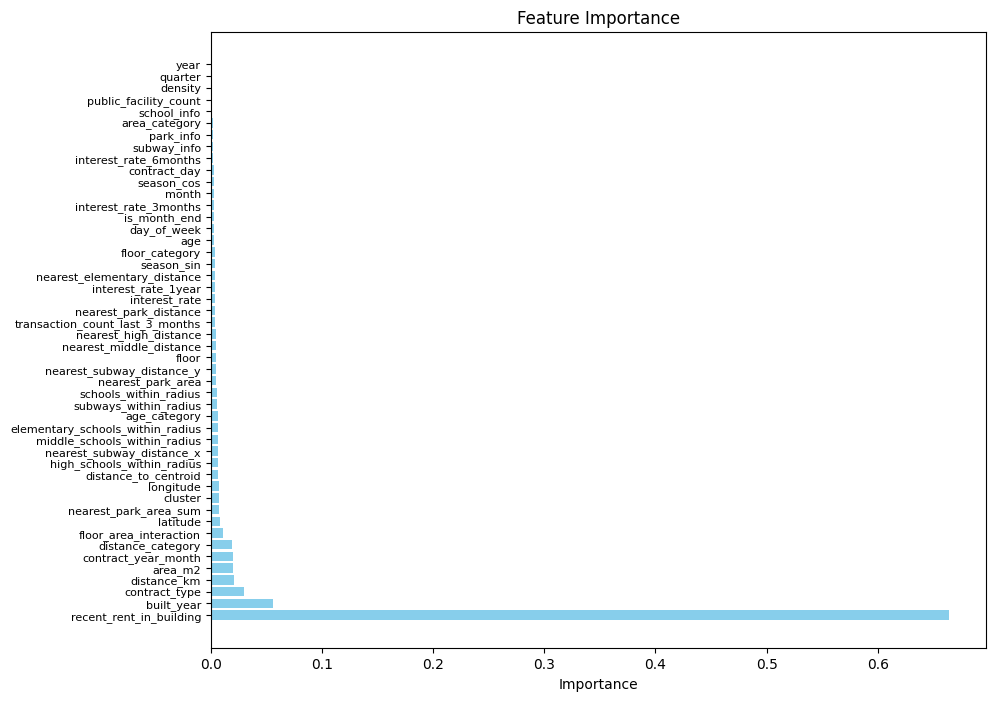

In [114]:
# Feature importance 시각화
plt.figure(figsize=(10,8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.yticks(fontsize=8)
plt.title('Feature Importance')
plt.show()

In [122]:
feature_new = ['recent_rent_in_building',
 'built_year',
 'contract_type',
 'distance_km',
 'area_m2',
 'subway_info',
 'contract_year_month',
 'distance_category',
 'floor_area_interaction',
 'latitude',
 'nearest_park_area_sum',
 'cluster',
 'longitude',
 'distance_to_centroid',
 'high_schools_within_radius',
 'nearest_subway_distance_x',
 'nearest_subway_distance_y',
 'middle_schools_within_radius',
 'elementary_schools_within_radius',
 'subways_within_radius',
 'schools_within_radius'
]
# feature split
train_data_20 = train_data_scaled[feature_new + ['deposit']]
valid_data_20 = valid_data_scaled[feature_new + ['deposit']]
test_data_20 = test_data_scaled[feature_new]

X_train, y_train, X_valid, y_valid, X_test = common_utils.split_feature_target(train_data_20, valid_data_20, test_data_20)

model_ = model.xgboost(X_train, y_train)
prediction, mae = inference(model_, 'validation', X_valid, y_valid)

validation Mae score
4030.9877447989966


In [118]:
# feature split
train_data_20 = train_data_scaled[top_20_features[:10] + ['deposit']]
valid_data_20 = valid_data_scaled[top_20_features[:10] + ['deposit']]
test_data_20 = test_data_scaled[top_20_features[:10]]

X_train, y_train, X_valid, y_valid, X_test = common_utils.split_feature_target(train_data_20, valid_data_20, test_data_20)

model_ = model.xgboost(X_train, y_train)
prediction, mae = inference(model_, 'validation', X_valid, y_valid)

validation Mae score
4060.2222618440906


In [123]:
# record MAE score as csv
hyperparams = "learning_rate=0.3, n_estimators=1000, enable_categorical=True, random_state=Config.RANDOM_SEED"
# train with total dataset
print("Training with total dataset...")
X_total, y_total = common_utils.train_valid_concat(X_train, X_valid, y_train, y_valid)
model_ = model.xgboost(X_total, y_total)

# inference with test data
submission = inference(model_, 'submission', X_test)

# save sample submission
submission_path = os.path.join("/data/ephemeral/home/level2-competitiveds-recsys-01/result", "submission")
os.makedirs(submission_path, exist_ok=True)

submission_file_path = os.path.join(submission_path, 'plus deposit features(1-last deposit)+version2+xgboost')
submission.to_csv(submission_file_path, index=False, encoding='utf-8-sig')

print("Successfully executed main.py.")

Training with total dataset...
Successfully executed main.py.
